In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1 — Imports, paths, basic setup
import os
import json
import math
import random

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

PROJ        = "/content/drive/MyDrive/VQAScore_Project"
RAW_CSV  = f"{PROJ}/results/raw_scores.csv"       # from improved Phase 3
TEMPLATE_CSV= f"{PROJ}/results/template_scores.csv"
TEMPLATE_VAR_CSV = f"{PROJ}/results/template_variance_summary.csv"
NEGATION_CSV= f"{PROJ}/results/negation_results.csv"

PLOTS_DIR   = f"{PROJ}/results/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Project:", PROJ)
print("Raw scores:", RAW_CSV)
print("Template scores:", TEMPLATE_CSV)
print("Negation scores:", NEGATION_CSV)

Project: /content/drive/MyDrive/VQAScore_Project
Raw scores: /content/drive/MyDrive/VQAScore_Project/results/raw_scores.csv
Template scores: /content/drive/MyDrive/VQAScore_Project/results/template_scores.csv
Negation scores: /content/drive/MyDrive/VQAScore_Project/results/negation_results.csv


In [3]:
# Cell 2 — Load dataframes (with graceful handling if some are missing)
df_raw = pd.read_csv(RAW_CSV)
print("df_raw:", df_raw.shape)

df_template = None
if os.path.exists(TEMPLATE_CSV):
    df_template = pd.read_csv(TEMPLATE_CSV)
    print("df_template:", df_template.shape)
else:
    print("No template_scores.csv found; template analysis will be skipped.")

df_template_var = None
if os.path.exists(TEMPLATE_VAR_CSV):
    df_template_var = pd.read_csv(TEMPLATE_VAR_CSV)
    print("df_template_variance:", df_template_var.shape)
else:
    print("No template_variance_summary.csv found; variance summary will be skipped.")

df_neg = None
if os.path.exists(NEGATION_CSV):
    df_neg = pd.read_csv(NEGATION_CSV)
    print("df_negation:", df_neg.shape)
else:
    print("No negation_results.csv found; negation analysis will only use heuristics from raw.")

df_raw: (1341, 9)
df_template: (3000, 8)
df_template_variance: (750, 8)
df_negation: (293, 10)


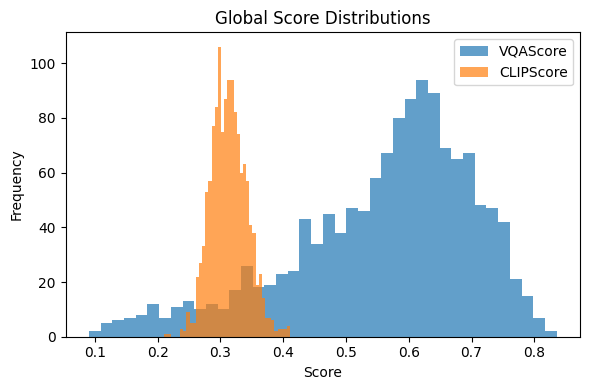

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/score_distribution_global.png
Global Spearman(VQA, CLIP) = 0.332
Global Pearson(VQA, CLIP)  = 0.300


In [4]:
# Cell 3 — Global distributions & correlations (over all prompts)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(df_raw["VQAScore"], bins=40, alpha=0.7, label="VQAScore")
ax.hist(df_raw["CLIPScore"], bins=40, alpha=0.7, label="CLIPScore")
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_title("Global Score Distributions")
ax.legend()
plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, "score_distribution_global.png")
plt.savefig(out_path, dpi=160)
plt.show()
print("Saved:", out_path)

rho, _ = spearmanr(df_raw["VQAScore"], df_raw["CLIPScore"])
r, _   = pearsonr(df_raw["VQAScore"], df_raw["CLIPScore"])
print(f"Global Spearman(VQA, CLIP) = {rho:.3f}")
print(f"Global Pearson(VQA, CLIP)  = {r:.3f}")

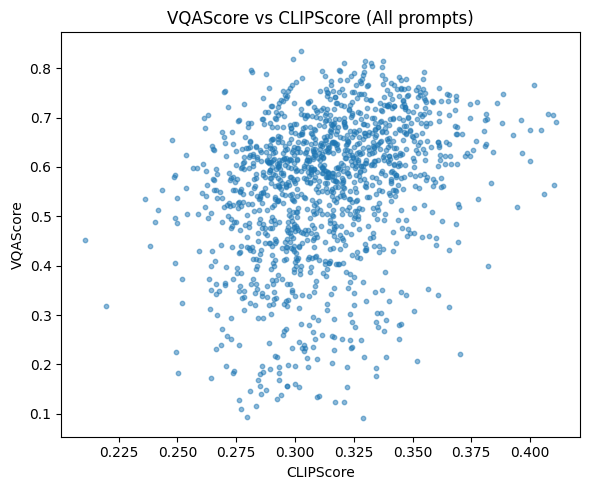

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/scatter_vqa_vs_clip_all.png


In [5]:
# Cell 4 — Scatter plot: VQAScore vs CLIPScore (all prompts)
plt.figure(figsize=(6,5))
plt.scatter(df_raw["CLIPScore"], df_raw["VQAScore"], s=10, alpha=0.5)
plt.xlabel("CLIPScore")
plt.ylabel("VQAScore")
plt.title("VQAScore vs CLIPScore (All prompts)")
plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, "scatter_vqa_vs_clip_all.png")
plt.savefig(out_path, dpi=160)
plt.show()
print("Saved:", out_path)

In [7]:
# Cell 5 — Correlations by category (simple / compositional / negation)
if "category" in df_raw.columns:
    cats = sorted(df_raw["category"].unique())
    rows = []
    for c in cats:
        sub = df_raw[df_raw["category"] == c]
        if len(sub) < 3:
            continue
        s_rho, _ = spearmanr(sub["VQAScore"], sub["CLIPScore"])
        s_r, _   = pearsonr(sub["VQAScore"], sub["CLIPScore"])
        rows.append({"category": c, "spearman": s_rho, "pearson": s_r})

    df_cat_corr = pd.DataFrame(rows)
    print("Correlations by category:")
    display(df_cat_corr)
else:
    print("No 'category' column found in df_raw; skipping per-category correlations.")

Correlations by category:


,category,spearman,pearson
0,compositional,0.274644,0.249252
1,negation,0.110221,0.094062
2,simple,0.337325,0.315766


Template-level stats:


,template,VQA_mean,VQA_std,VQA_min,VQA_max,n
2235,"Is there ""a tree without any leaves."" in this ...",0.872782,NaN,0.872782,0.872782,1
1948,"Is there ""A wooden shoe rack."" in this image? ...",0.864539,NaN,0.864539,0.864539,1
1682,"Is there ""A group of children playing on the b...",0.862236,NaN,0.862236,0.862236,1
2224,"Is there ""a pair of ballet shoes hanging by th...",0.859899,NaN,0.859899,0.859899,1
1889,"Is there ""A striped towel on a beach."" in this...",0.851953,NaN,0.851953,0.851953,1
...,...,...,...,...,...,...
63,"Does the photo depict ""A car, not red, without...",0.098079,NaN,0.098079,0.098079,1
265,"Does the photo depict ""A mountain with no snow...",0.093017,NaN,0.093017,0.093017,1
813,"Does this figure show ""A car, not red, without...",0.092688,NaN,0.092688,0.092688,1
1343,"Does this figure show ""On the subway, none of ...",0.090414,NaN,0.090414,0.090414,1


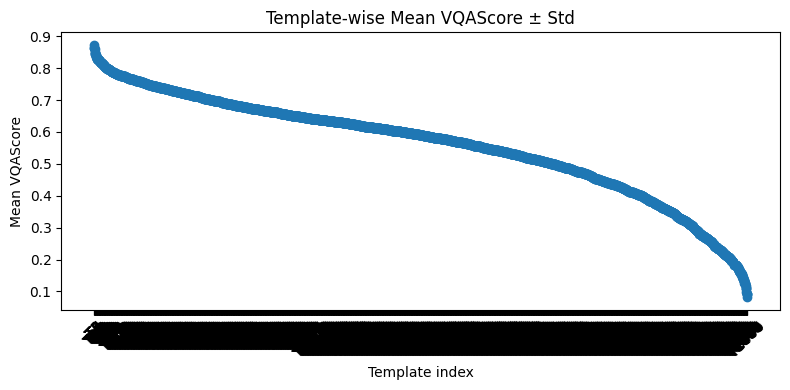

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/templates_vqa_mean_std.png


KeyError: 'spearman'

In [8]:
# Cell 6 — Template-level analysis (means/stds per template)
if df_template is not None and not df_template.empty:
    # Aggregate by template
    tmpl_stats = (
        df_template
        .groupby("template")
        .agg(
            VQA_mean=("VQAScore_template","mean"),
            VQA_std=("VQAScore_template","std"),
            VQA_min=("VQAScore_template","min"),
            VQA_max=("VQAScore_template","max"),
            n=("VQAScore_template","count")
        )
        .reset_index()
        .sort_values("VQA_mean", ascending=False)
    )
    print("Template-level stats:")
    display(tmpl_stats)

    # Plot means with errorbars
    plt.figure(figsize=(8,4))
    x = np.arange(len(tmpl_stats))
    plt.errorbar(x, tmpl_stats["VQA_mean"], yerr=tmpl_stats["VQA_std"], fmt="o")
    plt.xticks(x, [f"T{i+1}" for i in range(len(tmpl_stats))], rotation=45)
    plt.ylabel("Mean VQAScore")
    plt.xlabel("Template index")
    plt.title("Template-wise Mean VQAScore ± Std")
    plt.tight_layout()
    out_path = os.path.join(PLOTS_DIR, "templates_vqa_mean_std.png")
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved:", out_path)

    # Optional: correlation per template between template VQA and CLIPScore
    rows = []
    for tmpl, sub in df_template.groupby("template"):
        if len(sub) < 3:
            continue
        s_rho, _ = spearmanr(sub["VQAScore_template"], sub["CLIPScore"])
        s_r, _   = pearsonr(sub["VQAScore_template"], sub["CLIPScore"])
        rows.append({"template": tmpl, "spearman": s_rho, "pearson": s_r, "n": len(sub)})
    df_tmpl_corr = pd.DataFrame(rows).sort_values("spearman", ascending=False)
    print("Template-wise VQA–CLIP correlations:")
    display(df_tmpl_corr)
else:
    print("No template-level data; skipping template analysis.")

Template-level stats:


,template,VQA_mean,VQA_std,VQA_min,VQA_max,n
2235,"Is there ""a tree without any leaves."" in this ...",0.872782,NaN,0.872782,0.872782,1
1948,"Is there ""A wooden shoe rack."" in this image? ...",0.864539,NaN,0.864539,0.864539,1
1682,"Is there ""A group of children playing on the b...",0.862236,NaN,0.862236,0.862236,1
2224,"Is there ""a pair of ballet shoes hanging by th...",0.859899,NaN,0.859899,0.859899,1
1889,"Is there ""A striped towel on a beach."" in this...",0.851953,NaN,0.851953,0.851953,1
...,...,...,...,...,...,...
63,"Does the photo depict ""A car, not red, without...",0.098079,NaN,0.098079,0.098079,1
265,"Does the photo depict ""A mountain with no snow...",0.093017,NaN,0.093017,0.093017,1
813,"Does this figure show ""A car, not red, without...",0.092688,NaN,0.092688,0.092688,1
1343,"Does this figure show ""On the subway, none of ...",0.090414,NaN,0.090414,0.090414,1


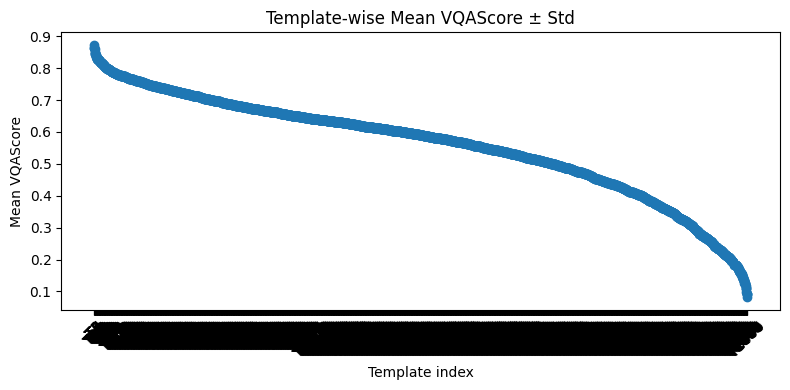

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/templates_vqa_mean_std.png


KeyError: 'spearman'

In [9]:
# Cell 6 — Template-level analysis (means/stds per template)
if df_template is not None and not df_template.empty:
    # Aggregate by template
    tmpl_stats = (
        df_template
        .groupby("template")
        .agg(
            VQA_mean=("VQAScore_template","mean"),
            VQA_std=("VQAScore_template","std"),
            VQA_min=("VQAScore_template","min"),
            VQA_max=("VQAScore_template","max"),
            n=("VQAScore_template","count")
        )
        .reset_index()
        .sort_values("VQA_mean", ascending=False)
    )
    print("Template-level stats:")
    display(tmpl_stats)

    # Plot means with errorbars
    plt.figure(figsize=(8,4))
    x = np.arange(len(tmpl_stats))
    plt.errorbar(x, tmpl_stats["VQA_mean"], yerr=tmpl_stats["VQA_std"], fmt="o")
    plt.xticks(x, [f"T{i+1}" for i in range(len(tmpl_stats))], rotation=45)
    plt.ylabel("Mean VQAScore")
    plt.xlabel("Template index")
    plt.title("Template-wise Mean VQAScore ± Std")
    plt.tight_layout()
    out_path = os.path.join(PLOTS_DIR, "templates_vqa_mean_std.png")
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved:", out_path)

    # Optional: correlation per template between template VQA and CLIPScore
    rows = []
    for tmpl, sub in df_template.groupby("template"):
        if len(sub) < 3:
            continue
        s_rho, _ = spearmanr(sub["VQAScore_template"], sub["CLIPScore"])
        s_r, _   = pearsonr(sub["VQAScore_template"], sub["CLIPScore"])
        rows.append({"template": tmpl, "spearman": s_rho, "pearson": s_r, "n": len(sub)})
    df_tmpl_corr = pd.DataFrame(rows).sort_values("spearman", ascending=False)
    print("Template-wise VQA–CLIP correlations:")
    display(df_tmpl_corr)
else:
    print("No template-level data; skipping template analysis.")

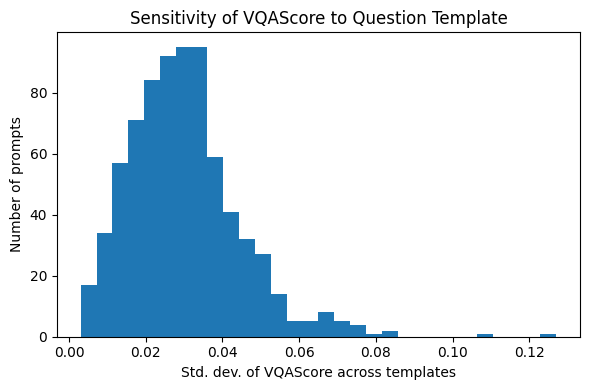

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/template_variance_hist.png
Template variance summary:


,VQA_std
count,750.000000
mean,0.030142
std,0.014628
min,0.003041
25%,0.020142
50%,0.028803
75%,0.037220
max,0.127026


In [10]:
# Cell 7 — Template variance distribution across prompts
if df_template_var is not None and not df_template_var.empty:
    plt.figure(figsize=(6,4))
    plt.hist(df_template_var["VQA_std"].fillna(0.0), bins=30)
    plt.xlabel("Std. dev. of VQAScore across templates")
    plt.ylabel("Number of prompts")
    plt.title("Sensitivity of VQAScore to Question Template")
    plt.tight_layout()
    out_path = os.path.join(PLOTS_DIR, "template_variance_hist.png")
    plt.savefig(out_path, dpi=160)
    plt.show()
    print("Saved:", out_path)

    print("Template variance summary:")
    display(df_template_var["VQA_std"].describe())
else:
    print("No template variance summary; skipping variance histogram.")

In [11]:
# Cell 8 — Negation analysis: compare negation vs non-negation distributions
def negation_flag(prompt: str) -> bool:
    p = str(prompt).lower()
    terms = [" no ", " not ", " without ", " except ", " minus "]
    return any(t in f" {p} " for t in terms) or p.startswith("no ")

if df_neg is not None and not df_neg.empty:
    # Use precomputed negation subset
    neg = df_neg.copy()
    nonneg = df_raw[~df_raw["id"].isin(neg["id"])].copy()
else:
    # Build negation slice directly from df_raw using heuristic
    df_raw["negation_flag"] = df_raw["prompt"].apply(negation_flag)
    neg = df_raw[df_raw["negation_flag"] == True].copy()
    nonneg = df_raw[df_raw["negation_flag"] == False].copy()

print("Negation samples:", len(neg))
print("Non-negation samples:", len(nonneg))

# Basic stats
print("\nCLIPScore stats (negation):")
display(neg["CLIPScore"].describe())
print("\nCLIPScore stats (non-negation):")
display(nonneg["CLIPScore"].describe())

print("\nVQAScore stats (negation):")
display(neg["VQAScore"].describe())
print("\nVQAScore stats (non-negation):")
display(nonneg["VQAScore"].describe())

Negation samples: 293
Non-negation samples: 1048

CLIPScore stats (negation):


,CLIPScore
count,293.000000
mean,0.300645
std,0.026550
min,0.219709
25%,0.284606
50%,0.298834
75%,0.314837
max,0.405980



CLIPScore stats (non-negation):


,CLIPScore
count,1048.000000
mean,0.316991
std,0.028316
min,0.210653
25%,0.296844
50%,0.316208
75%,0.336275
max,0.411198



VQAScore stats (negation):


,VQAScore
count,293.000000
mean,0.464283
std,0.150393
min,0.093017
25%,0.361165
50%,0.498047
75%,0.570331
max,0.795658



VQAScore stats (non-negation):


,VQAScore
count,1048.000000
mean,0.584103
std,0.134283
min,0.090735
25%,0.513059
50%,0.610221
75%,0.679391
max,0.835484


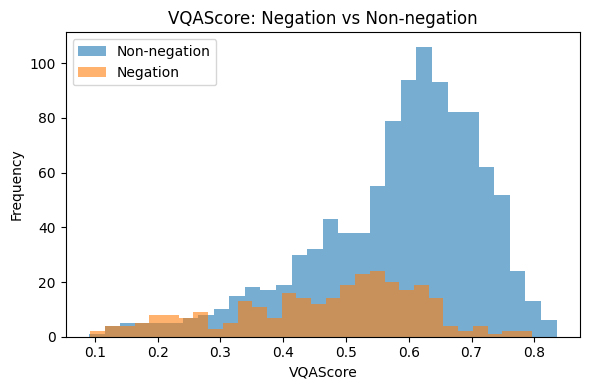

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/hist_vqa_neg_vs_nonneg.png


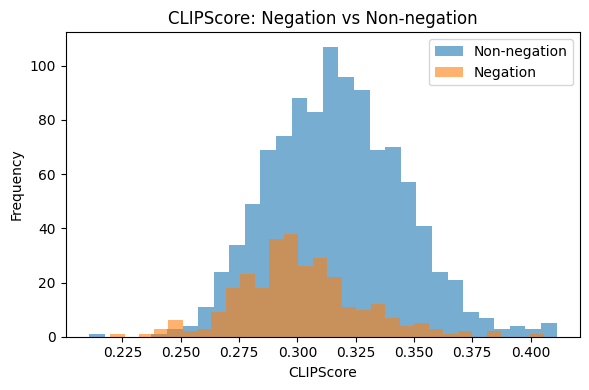

Saved: /content/drive/MyDrive/VQAScore_Project/results/plots/hist_clip_neg_vs_nonneg.png


In [12]:
# Cell 9 — Visualize negation vs non-negation distributions
# Histograms for VQAScore
plt.figure(figsize=(6,4))
plt.hist(nonneg["VQAScore"], bins=30, alpha=0.6, label="Non-negation")
plt.hist(neg["VQAScore"], bins=30, alpha=0.6, label="Negation")
plt.xlabel("VQAScore")
plt.ylabel("Frequency")
plt.title("VQAScore: Negation vs Non-negation")
plt.legend()
plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, "hist_vqa_neg_vs_nonneg.png")
plt.savefig(out_path, dpi=160)
plt.show()
print("Saved:", out_path)

# Histograms for CLIPScore
plt.figure(figsize=(6,4))
plt.hist(nonneg["CLIPScore"], bins=30, alpha=0.6, label="Non-negation")
plt.hist(neg["CLIPScore"], bins=30, alpha=0.6, label="Negation")
plt.xlabel("CLIPScore")
plt.ylabel("Frequency")
plt.title("CLIPScore: Negation vs Non-negation")
plt.legend()
plt.tight_layout()
out_path = os.path.join(PLOTS_DIR, "hist_clip_neg_vs_nonneg.png")
plt.savefig(out_path, dpi=160)
plt.show()
print("Saved:", out_path)

In [ ]:
# Cell 11 — Simple textual summary for report use
summary = {}

# Global
rho, _ = spearmanr(df_raw["VQAScore"], df_raw["CLIPScore"])
r, _   = pearsonr(df_raw["VQAScore"], df_raw["CLIPScore"])
summary["global_spearman"] = float(rho)
summary["global_pearson"]  = float(r)

# Negation gap (if available)
if len(neg) > 0 and len(nonneg) > 0:
    summary["negation_vqa_mean"]    = float(neg["VQAScore"].mean())
    summary["nonneg_vqa_mean"]      = float(nonneg["VQAScore"].mean())
    summary["negation_clip_mean"]   = float(neg["CLIPScore"].mean())
    summary["nonneg_clip_mean"]     = float(nonneg["CLIPScore"].mean())
    summary["delta_vqa_mean"]       = summary["nonneg_vqa_mean"] - summary["negation_vqa_mean"]
    summary["delta_clip_mean"]      = summary["nonneg_clip_mean"] - summary["negation_clip_mean"]

# Template sensitivity (if available)
if df_template_var is not None and not df_template_var.empty:
    summary["template_vqa_std_mean"] = float(df_template_var["VQA_std"].mean())
    summary["template_vqa_std_median"] = float(df_template_var["VQA_std"].median())

print("Phase 5 summary (for copying into your report):")
import pprint
pprint.pprint(summary)

summary_path = os.path.join(PROJ, "results", "analysis_summary_phase5.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print("\nSaved JSON summary to:", summary_path)

Phase 5 summary (for copying into your report):
{'delta_clip_mean': 0.016346670044155853,
 'delta_vqa_mean': 0.11982083110567593,
 'global_pearson': 0.29969670153244377,
 'global_spearman': 0.3320109486432004,
 'negation_clip_mean': 0.30064460848785507,
 'negation_vqa_mean': 0.4642825678723366,
 'nonneg_clip_mean': 0.3169912785320109,
 'nonneg_vqa_mean': 0.5841033989780126,
 'template_vqa_std_mean': 0.03014199139618931,
 'template_vqa_std_median': 0.028803286370488047}

Saved JSON summary to: /content/drive/MyDrive/VQAScore_Project/results/analysis_summary_phase5.json

✅ Phase 5 complete. You now have plots + summary stats ready for the report and slides.
